In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import csv
import math
from scipy import optimize

In [2]:
%matplotlib inline

gyro = 1.6e-19/9.1e-31 #Gyromagnetic magnetic ratio (C/kg)

def Lorentzian(H, S, A, Delta, H0, V): 
    return ((S*Delta**2)+(A*(H-H0)*Delta))/(Delta**2+(H-H0)**2)+V
def damping(f, alpha, delta0):
    return 2*np.pi*(f*1e9)*alpha/gyro+delta0
def Kittel(H0, demag):
    return gyro/(2*np.pi)*(np.sqrt(H0*(H0+demag)))*1e-13
def data_slicing(sliced_array,slicing_ind):
    n = np.sum(slicing_ind)
    np.append(sliced_array,0)
    output = []
    if len(sliced_array) == n:
        cnt = 0
        for i in range(len(slicing_ind)):
            i_start=cnt
            cnt+=slicing_ind[i]
            i_stop=cnt
            output.append(sliced_array[i_start:i_stop])
    return output


In [4]:
gaussscan = '/Users/didierjim/Documents/SCREAM/_Measurement/ST-FMR field calibration/220406/step10/\
3000FIX.csv'
x2 = np.loadtxt(gaussscan,delimiter=',',skiprows=1,usecols=(0,2,))
print(np.shape(x2[:,:]))

(601, 2)


# DC-modulation

In [6]:
io = r'/Users/didierjim/Documents/SCREAM/_Measurement/2022-07-thickNM/SiO2.Co(t)/dc Co20/220822'
Sample_name = '_'
files = sorted(glob.glob(os.path.join(io,'*'+Sample_name+'*')), key = lambda path:float(path.split('_')[5].split('__Frequency')[0]))

In [8]:
IDC = []
for i in range(len(files)):
    IDC.append(float(files[i].split('_')[5].split('__Frequency')[0]))
#print(IDC)

file_count = []
Iappl = []
cnt = 1
for j in range(1,len(files)):
    if IDC[j] == IDC[j-1]:
        cnt += 1
    else:
        file_count.append(cnt)
        Iappl.append(IDC[j-1])
        cnt = 1
    if j == len(files)-1:
        file_count.append(cnt)
        Iappl.append(IDC[j])
print(np.sum(file_count), file_count)
print(Iappl)
for i in range(len(files)):
    print(files[i].split('/')[-1])

16 [4, 4, 4, 4]
[-1.5, -0.5, 0.5, 1.5]
228L121_DC-modulation_I_(mA)_-1.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-47-00.csv
228L121_DC-modulation_I_(mA)_-1.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-40-08.csv
228L121_DC-modulation_I_(mA)_-1.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-50-25.csv
228L121_DC-modulation_I_(mA)_-1.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-43-34.csv
228L121_DC-modulation_I_(mA)_-0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-44-26.csv
228L121_DC-modulation_I_(mA)_-0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-41-00.csv
228L121_DC-modulation_I_(mA)_-0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-51-17.csv
228L121_DC-modulation_I_(mA)_-0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-47-51.csv
228L121_DC-modulation_I_(mA)_0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-52-06.csv
228L121_DC-modulation_I_(mA)_0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-41-48.csv
228L121_DC-modulation_I_(mA)_0.5__Freq_(Ghz)_9.00_standard_2022-08-22-16-45-14.csv
228L121_DC-modulation_I_(mA)_0.5__Freq_(

In [9]:
# Find Hr
#import_files = pd.read_csv(files[int(len(files)/2-3)])
import_files = pd.read_csv(files[-3])
result = import_files.values
Datamax, Datamin = np.max(result[:,1]), np.min(result[:,1])
print(Datamax, Datamin)
Hr = float((result[result[:,1]==Datamax,0][0]+result[result[:,1]==Datamin,0][0])/2)
print('\nmax at',result[result[:,1]==Datamax,0][0],'Oe, min at',result[result[:,1]==Datamin,0][0], 'Oe, Hr =', Hr)
print(type(Hr))

max_ind = int(np.where(result[:,1]==Datamax)[0][0])
min_ind = int(np.where(result[:,1]==Datamin)[0][0])

if max_ind > min_ind:
    p_ind, n_ind = min_ind, max_ind
elif max_ind < min_ind:
    p_ind, n_ind = max_ind, min_ind
    
print(p_ind, n_ind)

1242.66 1216.85

max at -900.0 Oe, min at 100.0 Oe, Hr = -400.0
<class 'float'>
145 195


In [16]:
Hr = -200

para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []
points = 120

plt.figure(figsize = (15,10))
for i in range(len(files)):
#for i in range(5):
    import_files = pd.read_csv(files[i])
    result = import_files.values
    Datamax, Datamin = np.max(result[:,1]), np.min(result[:,1])
    #Hr = float(((result[result[:,1]==Datamax,0]+result[result[:,1]==Datamin,0])/2)[0])
    
    max_ind = int(np.where(result[:,1]==Datamax)[0][0])
    min_ind = int(np.where(result[:,1]==Datamin)[0][0])

    if max_ind > min_ind:
        p_ind, n_ind = min_ind, max_ind
    elif max_ind < min_ind:
        p_ind, n_ind = max_ind, min_ind
    
    results = pd.read_csv(files[i])
    length = len(results.values[:,0])
    #H_p = results.values[p_ind-points:p_ind+points,0]-Hr
    #Vmix_p = results.values[p_ind-points:p_ind+points,1]
    H_p0 = results.values[int(length*0.35):int(length*0.4),0]-Hr
    H_p = x2[int(length*0.35):int(length*0.4),1]*-1
    Vmix_p = results.values[int(length*0.35):int(length*0.4),1]
    if p_ind-points < 0 or n_ind+points > len(results.values):
        print('Fitting Region chosen is too large!!!!')
    
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    para_L, cov_L = optimize.curve_fit(Lorentzian,H_p,Vmix_p, [1.0, 1.0, 100, 500, 280])
    plt.figure(figsize = (10,6))
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = files[i].split('/')[-1].split('_')[-1],color = 'black', linewidth = 2)
    para_p[i,0] = IDC[i]
    para_p[i,1:] = para_L
    std_err_p.append(np.sqrt(np.diag(cov_L))[2])
    
    #H_n = results.values[n_ind-points:n_ind+points,0]-Hr
    #Vmix_n = results.values[n_ind-points:n_ind+points,1]
    H_n0 = results.values[int(length*0.57):int(length*0.85),0]-Hr
    H_n = x2[int(length*0.57):int(length*0.85),1]*-1
    Vmix_n = results.values[int(length*0.57):int(length*0.85),1]
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    para_L, cov_L = optimize.curve_fit(Lorentzian,H_n,Vmix_n, [0.0, 0.0, -80, -1000, 280])
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = IDC[i],color = 'black', linewidth = 2)
    para_n[i,0] = IDC[i]
    para_n[i,1:] = para_L
    std_err_n.append(np.sqrt(np.diag(cov_L))[2])

    plt.legend()


Fitting Region chosen is too large!!!!


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

<Figure size 1080x720 with 0 Axes>

positive SHA++++++++
p= -0.092 +- 0.055 
n= 0.014 +- 0.037


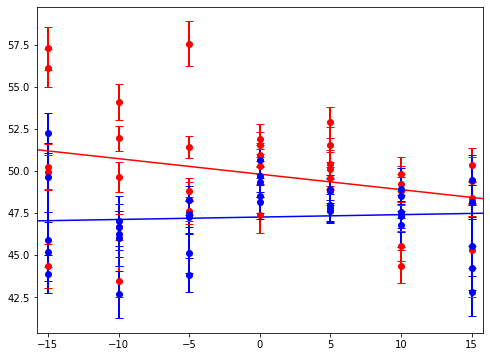

In [40]:
#error bar by linewidth fitting

plt.figure(figsize = (8,6))
plt.errorbar(IDC, abs(para_p[:,3]),yerr = std_err_p, fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
plt.errorbar(IDC, abs(para_n[:,3]),yerr = std_err_n, fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)
plt.xlim(np.min(Iappl)-0.8,np.max(Iappl)+0.8)
#plt.ylim(100,160)

x = np.arange(np.min(Iappl)-1,np.max(Iappl)+1,0.1)
Rp, Covp = np.polyfit(IDC, abs(para_p[:,3]),1,cov=True)
Rn,Covn = np.polyfit(IDC, abs(para_n[:,3]),1,cov=True)

if Rp[0]>0 and Rn[0]<0:
    print('negative SHA--------')
elif Rp[0]<0 and Rn[0]>0:
    print('positive SHA++++++++')
    
print('p=',np.around(Rp[0],3),'+-',np.around(np.sqrt(np.diag(Covp))[0],3),
      '\nn=',np.around(Rn[0],3),'+-',np.around(np.sqrt(np.diag(Covn))[0],3))
plt.plot(x,Rp[0]*x+Rp[1],color='r')
plt.plot(x,Rn[0]*x+Rn[1],color='b')

#for i in range(len(IDC)):
#    print(IDC[i],abs(para_p[i,3]),std_err_p[i],abs(para_n[i,3]),std_err_n[i])

IDC= -15.0 	Dp= [44.35 50.24 56.13 49.95 57.28]
IDC= -10.0 	Dp= [51.93 43.42 54.12 49.63 46.65]
IDC= -5.0 	Dp= [51.4  48.81 47.64 48.28 57.55]
IDC= 0.0 	Dp= [51.9  47.39 50.96 51.55 50.26]
IDC= 5.0 	Dp= [50.38 52.88 49.56 50.14 51.57]
IDC= 10.0 	Dp= [49.21 44.33 45.54 48.8  49.82]
IDC= 15.0 	Dp= [48.13 45.28 48.36 50.34 49.42]

p= -0.092 +- 0.046 
n= 0.014 +- 0.053


Text(0.5, 1.0, 'shifted')

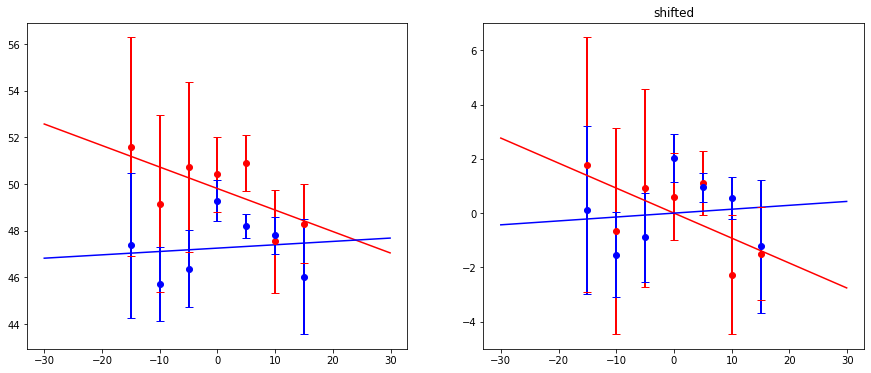

In [27]:
#error bar by multiple measurements
Delta_p_all = data_slicing(abs(para_p[:,3]),file_count)
Delta_n_all = data_slicing(abs(para_n[:,3]),file_count)

Delta_p = []
Delta_n = []
Dp_err = []
Dn_err = []

for k in range(len(file_count)):
    Delta_p.append(np.mean(Delta_p_all[k]))
    Delta_n.append(np.mean(Delta_n_all[k]))
    Dp_err.append(np.std(Delta_p_all[k]))
    Dn_err.append(np.std(Delta_n_all[k]))
    print('IDC=',Iappl[k],'\tDp=',np.around(Delta_p_all[k],2))
    
x = np.arange(np.min(Iappl)*2,np.max(Iappl)*2,0.1)
Z1,covz1 = np.polyfit(Iappl,Delta_p,1,cov=True)
Z2,covz2 = np.polyfit(Iappl,Delta_n,1,cov=True)

plt.figure(figsize = (15,6))
plt.subplot(121)
plt.plot(x,Z1[0]*x+Z1[1],color='r')
plt.plot(x,Z2[0]*x+Z2[1],color='b')
        
plt.errorbar(Iappl,Delta_p,yerr=Dp_err, fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
plt.errorbar(Iappl,Delta_n,yerr=Dn_err, fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)

plt.subplot(122)

plt.plot(x,Z1[0]*x,color='r')
plt.plot(x,Z2[0]*x,color='b')
print('\np=',np.around(Z1[0],3),'+-',np.around(np.sqrt(np.diag(covz1))[0],3),
      '\nn=',np.around(Z2[0],3),'+-',np.around(np.sqrt(np.diag(covz2))[0],3))
        
plt.errorbar(Iappl,Delta_p-Z1[1],yerr=Dp_err, fmt='o',ecolor='r',color='r',elinewidth=2,capsize=4)
plt.errorbar(Iappl,Delta_n-Z2[1],yerr=Dn_err, fmt='o',ecolor='b',color='b',elinewidth=2,capsize=4)
#print('Delta=\t',np.around(Delta_p,1))
#print('err=\t',np.around(Dp_err,2))
plt.title('shifted')

In [28]:
#Output data
filename = '225deg-Cr20Co15'

#Construct dict
DATA_dict = {"Iappl_raw":IDC,
             "Dp_raw":abs(para_p[:,3]),
             "Dp_raw_err":std_err_p,
             "Dn_raw":abs(para_n[:,3]),
             "Dn_raw_err":std_err_n,
             "Iappl":Iappl, 
             "Dp":Delta_p, 
             "Dp_shft":Delta_p-Z1[1],
             "Dp_err":Dp_err, 
             "Dn":Delta_n, 
             "Dn_shft":Delta_n-Z2[1],
             "Dn_err":Dn_err}

FIT_dict = {"x":x,
            "yp_raw":Rp[0]*x+Rp[1],
            "yn_raw":Rn[0]*x+Rn[1],
            "yp":Z1[0]*x+Z1[1],
            "yn":Z2[0]*x+Z2[1],
            "yp_shft":Z1[0]*x,
            "yn_shft":Z2[0]*x}


header = ''
OUTPUT = np.ones((len(x)+9,19))*np.nan

cnt = 0
for key in DATA_dict.keys():
    header+=key+'\t'
    l = len(DATA_dict[key])
    OUTPUT[:l,cnt] = DATA_dict[key]
    cnt+=1
    
for key in FIT_dict.keys():
    header+=key+'\t'
    l = len(FIT_dict[key])
    OUTPUT[:l,cnt] = FIT_dict[key]
    cnt+=1
#print(OUTPUT)

print(header)
np.savetxt(filename,OUTPUT,delimiter='\t',header=header)
print(np.average(para_p[:,4]))

Iappl_raw	Dp_raw	Dp_raw_err	Dn_raw	Dn_raw_err	Iappl	Dp	Dp_shft	Dp_err	Dn	Dn_shft	Dn_err	x	yp_raw	yn_raw	yp	yn	yp_shft	yn_shft	
511.5938409235167


(7, 5)


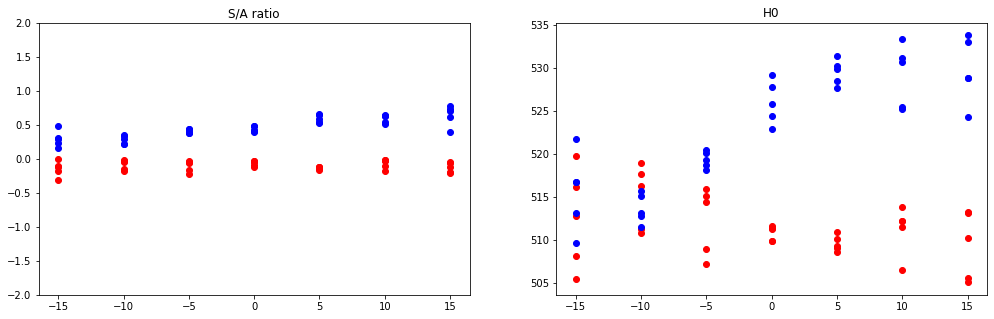

In [41]:
i = -2
ti=['Idc','S', 'A', 'Delta', 'H0', 'offset']

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(IDC,para_p[:,1]/para_p[:,2],'ro')
plt.plot(IDC,para_n[:,1]/para_n[:,2],'bo')
#plt.title(ti[i])
plt.title("S/A ratio")
print(np.shape(data_slicing(para_p[:,1],file_count)))
plt.ylim(-2,2)

plt.subplot(122)
plt.plot(IDC,para_p[:,i],'ro')
plt.plot(IDC,-para_n[:,i],'bo')
plt.title(ti[i])
#print(np.shape(data_slicing(para_p[:,i],file_count)))

for j in range(len(IDC)):
    #A = (IDC[j],para_p[j,1]/para_p[j,2],para_n[j,1]/para_n[j,2])
    A = (IDC[j],para_p[j,i],para_n[j,i])
    #print(A[0])

In [30]:
para_header='I_p\tS\tA\tSA\tH0\tV0\tI_n\tS\tA\tSA\tH0\tV0'
PARA = np.zeros((len(IDC),12))
for i in range(len(IDC)):
    PARA[i,0:6] = para_p[i,:]
    PARA[i,6:12] = para_n[i,:]

PARA[:,3] = PARA[:,1]/PARA[:,2]
PARA[:,9] = PARA[:,7]/PARA[:,8]
np.savetxt('PARAs '+filename,PARA,delimiter='\t',header=para_header)

In [224]:
data_slicing(abs(para_p[:,1]),file_count)

[array([41.29014599, 43.55255047, 44.25937721]),
 array([41.84650545, 42.98801016, 43.71726776]),
 array([45.12843447, 44.42471287, 45.08271233]),
 array([42.94224028, 43.07212454, 41.57935772]),
 array([43.27653542, 42.69427403, 41.93308044]),
 array([43.00135525, 41.70425622, 43.24774723]),
 array([43.37682834, 42.59859859, 43.44614793]),
 array([42.56060527, 42.45042803, 43.40232914]),
 array([41.54543493, 42.22948206, 43.45110427]),
 array([41.48146999, 41.62453948, 41.33313835]),
 array([38.92746403, 42.51662707, 40.50829532])]

In [82]:
#dc efficiency
import numpy as np

tHM = 4e-9 # thickness of spin Hall material (meters) 
tFM = 2e-9 # thickness of magnetic layer - dead layer (meters)
Ms = 640 * 1000 # saturization magnetization (A/m)
u0 = 4*3.14159e-7 #Vacuum permeability (Wb/(A*m))
hbar = 1.05e-34 #Planck's constant/2pi (m2*kg/s)
gyro = 1.6e-19/9.1e-31 #Gyromagnetic magnetic ratio (C/kg)
w = 5e-6
f = 7e9

H0 = 700/10000 #Tesla
Hd = 8050/10000 #Tesla
rhoHM = 200
rhoFM = 40

I = 2*np.pi*f/gyro
II = np.sin(45/180*np.pi)/((H0+Hd/2)*u0*Ms*tFM)*(hbar/(2*1.6e-19))
III = 1/w/(tHM+tFM*rhoHM/rhoFM)
factor = 1/I/II/III*1e6/4/np.pi

print('eff/slope = ',factor)
slope = np.array([4])
print(slope*factor)


#print('\neffp=',np.around(Z1[0]*factor,3),'+-',np.around(np.sqrt(np.diag(covz1))[0]*factor,3),
#      '\neffn=',np.around(Z2[0]*factor,3),'+-',np.around(np.sqrt(np.diag(covz2))[0]*factor,3))

#print('p=',np.around(Rp[0]*factor,3),'+-',np.around(np.sqrt(np.diag(Covp))[0]*factor,3),
#      '\nn=',np.around(Rn[0]*factor,3),'+-',np.around(np.sqrt(np.diag(Covn))[0]*factor,3))

eff/slope =  0.07294336845065136
[0.29177347]


In [38]:

SAfactor=1.6e-19*u0*Ms*tHM*tFM/hbar*np.sqrt(1+Hd/H0)

TR=-40
TRfactor=1.6e-19*u0*Ms*tHM*tFM/hbar
print('SA eff = ',TR*TRfactor)

SA eff =  -0.4545144700342856


In [101]:
#miltilayer dc efficiency
import numpy as np
#constant
u0 = 4*3.14159e-7 #Vacuum permeability (Wb/(A*m))
hbar = 1.05e-34 #Planck's constant/2pi (m2*kg/s)
gyro = 1.6e-19/9.1e-31 #Gyromagnetic magnetic ratio (C/kg)

#parameters
tHM = 1.5e-9 # thickness of spin Hall material (meters)
tFM = 5e-9 # thickness of magnetic layer - dead layer (meters)
tIN = 7e-9 # thickness of non-interacting layer (only for shunting) (meters)

Ms = 1026.26 * 1000 # saturization magnetization (A/m)
w = 10e-6
f = 9e9

H0 = 701/10000 #Tesla
Hd = 14500/10000 #Tesla
rhoHM = 27.4 #uOhm-cm
rhoFM = 26.6
rhoIN = 126.0

I = 2*np.pi*f/gyro #dW/dAlpha = linewidth-damping const conversion
II = np.sin(45/180*np.pi)/((H0+Hd/2)*u0*Ms*tFM)*(hbar/(2*1.6e-19)) #factors concerning FMR
III = (1/(w*tHM))*((tHM/rhoHM)/((tHM/rhoHM)+(tFM/rhoFM)+(tIN/rhoIN))) #current shunting
factor = 1/I/II/III*1e6/4/np.pi

print('eff/slope = ',factor)
slope = np.array([1.710,0.343,0.094,0.305])
print(slope*factor)

eff/slope =  0.4468284612342481
[0.76407667 0.15326216 0.04200188 0.13628268]
